In [1]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('CreditPrediction.csv').drop('Unnamed: 19', axis='columns')
print(df.shape)
df.head()

(10167, 19)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000


In [3]:
# Drop Unwanted Columns
df = df.drop('CLIENTNUM', axis='columns') # Identifier, not typically used as a feature for analysis

# Remove Duplicated Rows
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

(10132, 18)


In [4]:
# Check Garbage Values in Categorical Features
for col in df.select_dtypes(include="object").columns:
    print(df[col].value_counts())
    print("\n")

Gender
F    5247
M    4686
Name: count, dtype: int64


Education_Level
Graduate         3129
High School      2014
Unknown          1519
Uneducated       1488
College          1015
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64


Marital_Status
Married     3793
Single      3184
Unknown      621
Divorced     595
Name: count, dtype: int64


Income_Category
Less than $40K    3562
$40K - $60K       1791
$80K - $120K      1535
$60K - $80K       1402
Unknown           1115
$120K +            727
Name: count, dtype: int64


Card_Category
Blue        7644
Silver       461
Gold          96
Platinum      16
Name: count, dtype: int64




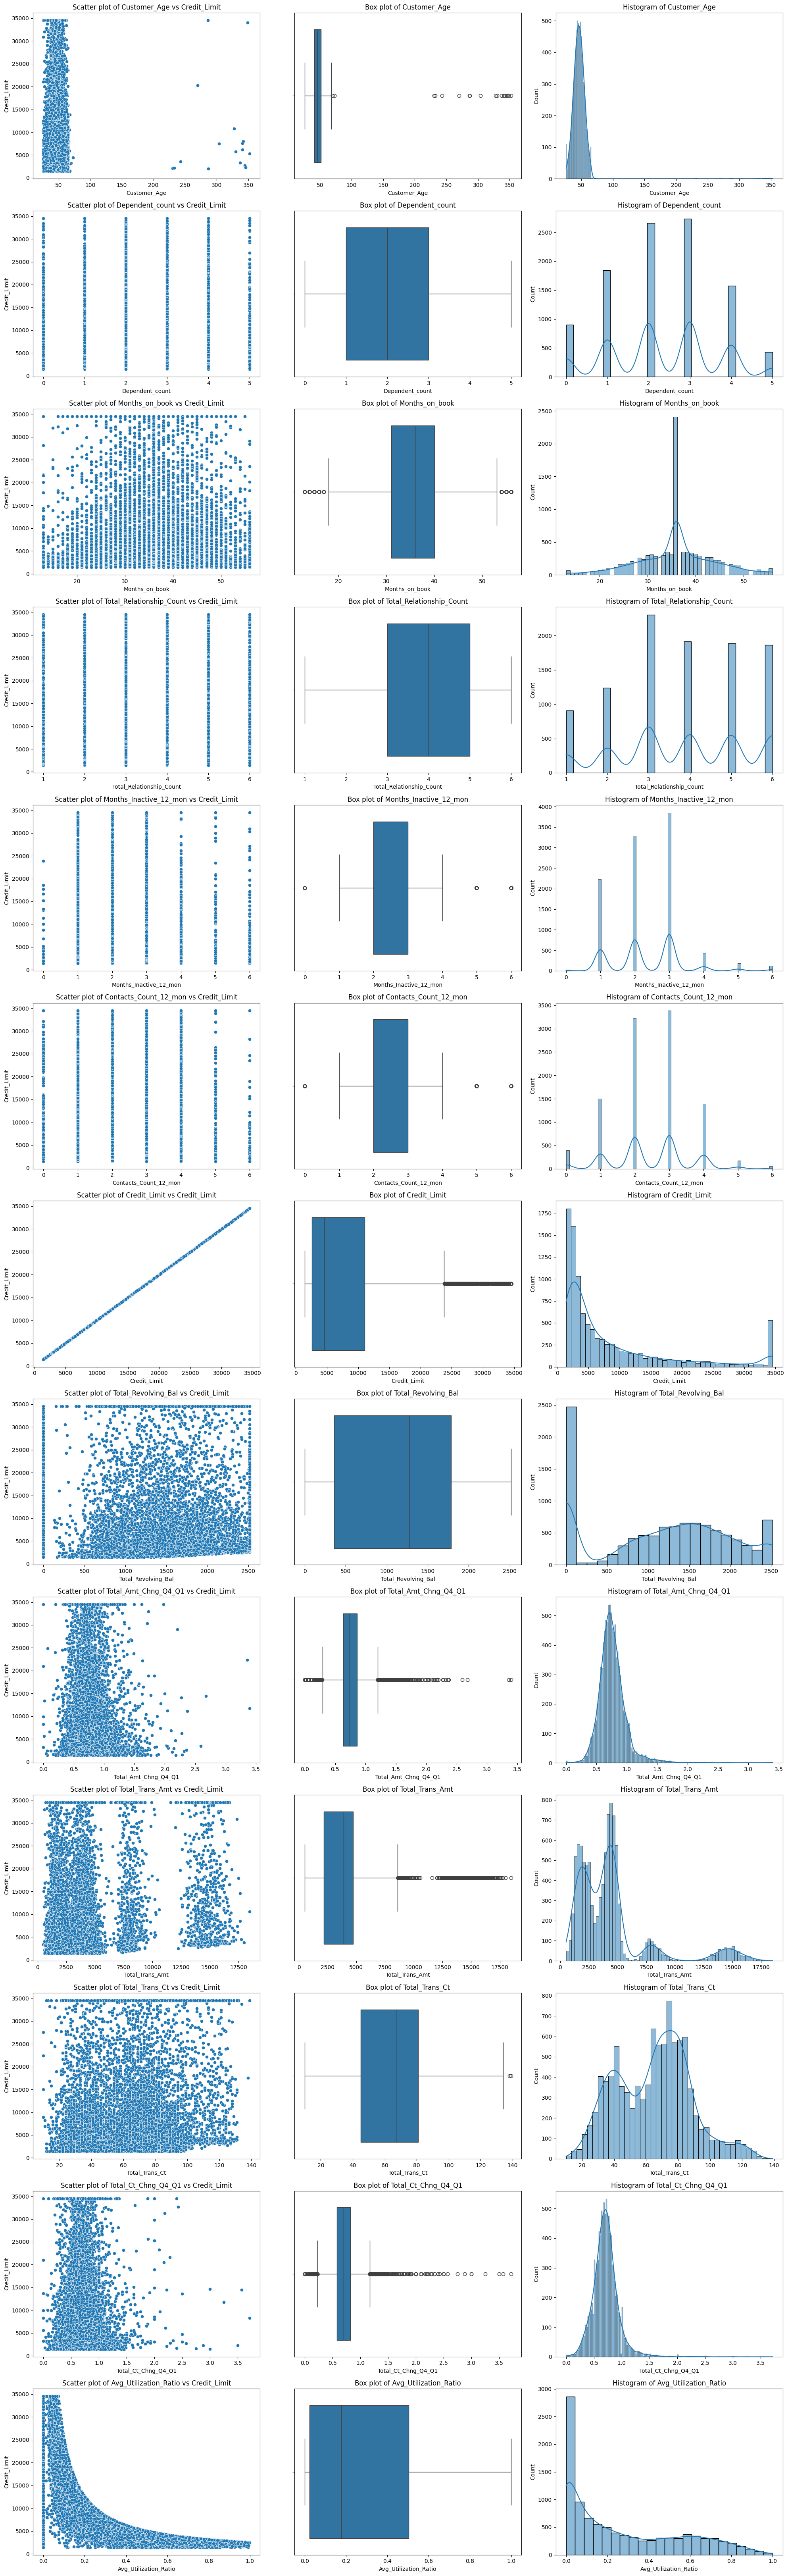

In [5]:
numeric_features = df.select_dtypes(include="number").columns

plt.figure(figsize=(20, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Scatter plot
    plt.subplot(len(numeric_features), 3, 3*i + 1)
    sns.scatterplot(data=df, x=feature, y='Credit_Limit')
    plt.title(f'Scatter plot of {feature} vs Credit_Limit')

    # Box plot to identify outliers
    plt.subplot(len(numeric_features), 3, 3*i + 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')

    # Histogram to understan distribiution
    plt.subplot(len(numeric_features), 3, 3*i + 3)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

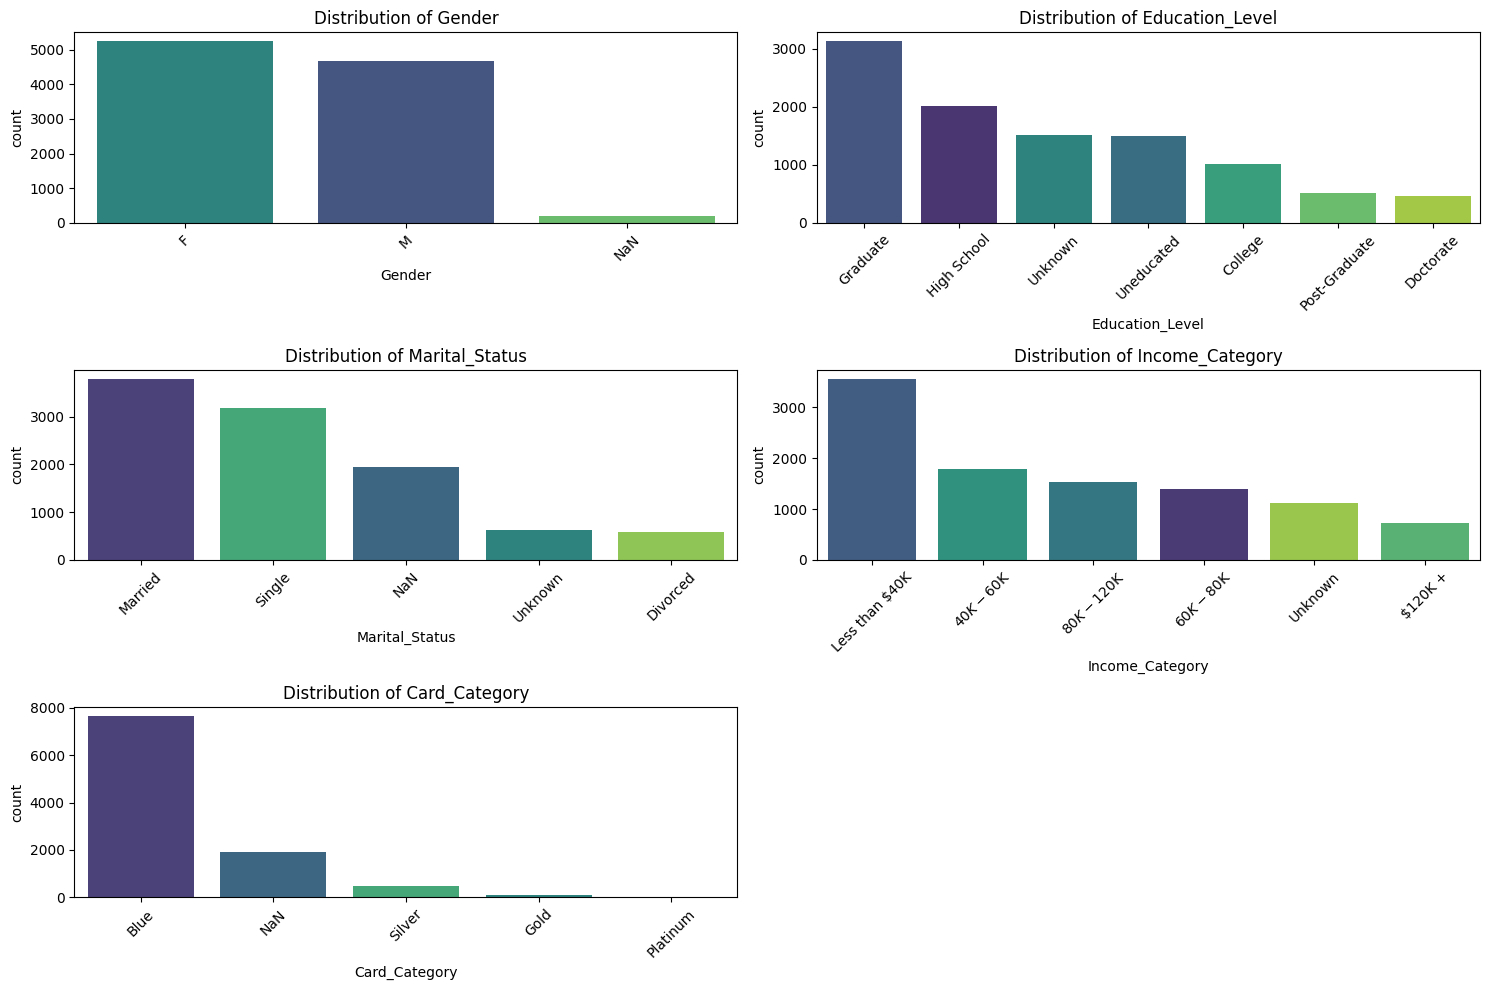

In [6]:
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
df[categorical_features] = df[categorical_features].fillna('NaN')

# Plot bar plots for each categorical feature including NaN values
plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=feature, hue=feature, order=df[feature].value_counts().index, palette="viridis", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

In [7]:
# Encoding 

# Define mappings for each ordinal categorical feature
education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3,
                     'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3,
                  '$80K - $120K': 4, '$120K +': 5}
card_mapping = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}

# Apply mapping to each categorical feature
df['Education_Level'] = df['Education_Level'].map(education_mapping)
df['Income_Category'] = df['Income_Category'].map(income_mapping)
df['Card_Category'] = df['Card_Category'].map(card_mapping)


# One-hot Encoding for nominal Categorical Features
columns_to_encode = ['Gender', 'Marital_Status']
encoder = OneHotEncoder(drop='first', dtype=np.float64, handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(df[columns_to_encode])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(columns_to_encode))
df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

df.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Gender_NaN,Marital_Status_Married,Marital_Status_NaN,Marital_Status_Single,Marital_Status_Unknown
0,45.0,3,2,3,0.0,39.0,5.0,1,3,12691.0,...,1144,42,1.625,0.061,1.0,0.0,1.0,0.0,0.0,0.0
1,49.0,5,4,1,0.0,44.0,6.0,1,2,8256.0,...,1291,33,3.714,0.105,0.0,0.0,0.0,1.0,0.0,0.0
2,51.0,3,4,4,0.0,36.0,4.0,1,0,3418.0,...,1887,20,2.333,0.000,1.0,0.0,1.0,0.0,0.0,0.0
3,40.0,4,2,1,0.0,34.0,3.0,4,1,3313.0,...,1171,20,2.333,0.760,0.0,0.0,0.0,1.0,0.0,0.0
4,40.0,3,1,3,NaN,21.0,5.0,1,0,4716.0,...,816,28,2.500,0.000,1.0,0.0,1.0,0.0,0.0,0.0


In [8]:
# fill NaN 
for column in columns_to_encode:
    nan_col = column + '_NaN'
    encoded_columns = [col for col in df.columns if col.startswith(column + '_') and col != nan_col]
    for encoded_col in encoded_columns:
        df.loc[df[nan_col] == 1, encoded_col] = np.nan

# Drop the NaN indicator columns
df = df.drop(columns=[col + '_NaN' for col in columns_to_encode])

df.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,45.0,3,2,3,0.0,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,1.0,1.0,0.0,0.0
1,49.0,5,4,1,0.0,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,0.0,NaN,NaN,NaN
2,51.0,3,4,4,0.0,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,1.0,1.0,0.0,0.0
3,40.0,4,2,1,0.0,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,0.0,NaN,NaN,NaN
4,40.0,3,1,3,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,1.0,1.0,0.0,0.0


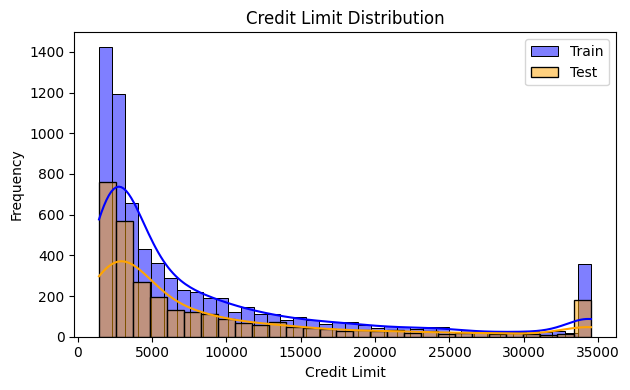

In [9]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

# Plot the distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Credit_Limit'], kde=True, color='blue', label='Train')
sns.histplot(test_df['Credit_Limit'], kde=True, color='orange', label='Test')
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7092.0,46.695730,14.156898,26.0,41.000,46.000,52.00000,352.330517
Dependent_count,7092.0,2.344614,1.298479,0.0,1.000,2.000,3.00000,5.000000
Education_Level,7092.0,2.603356,1.688691,0.0,1.000,3.000,4.00000,6.000000
Income_Category,7092.0,2.095178,1.470567,0.0,1.000,2.000,3.00000,5.000000
Card_Category,5767.0,0.086527,0.341850,0.0,0.000,0.000,0.00000,3.000000
Months_on_book,6931.0,35.874910,7.994826,13.0,31.000,36.000,40.00000,56.000000
Total_Relationship_Count,7076.0,3.807236,1.560786,1.0,3.000,4.000,5.00000,6.000000
Months_Inactive_12_mon,7092.0,2.340102,1.005953,0.0,2.000,2.000,3.00000,6.000000
Contacts_Count_12_mon,7092.0,2.453187,1.100086,0.0,2.000,2.000,3.00000,6.000000
Credit_Limit,7092.0,8581.610307,9001.880991,1438.3,2542.000,4561.500,11059.25000,34516.000000


In [11]:
nan_counts = train_df.isna().sum().sort_values(ascending=False)
summary = pd.concat([train_df.info(), nan_counts], axis=0)
summary

<class 'pandas.core.frame.DataFrame'>
Index: 7092 entries, 8678 to 7270
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              7092 non-null   float64
 1   Dependent_count           7092 non-null   int64  
 2   Education_Level           7092 non-null   int64  
 3   Income_Category           7092 non-null   int64  
 4   Card_Category             5767 non-null   float64
 5   Months_on_book            6931 non-null   float64
 6   Total_Relationship_Count  7076 non-null   float64
 7   Months_Inactive_12_mon    7092 non-null   int64  
 8   Contacts_Count_12_mon     7092 non-null   int64  
 9   Credit_Limit              7092 non-null   float64
 10  Total_Revolving_Bal       7092 non-null   int64  
 11  Total_Amt_Chng_Q4_Q1      7092 non-null   float64
 12  Total_Trans_Amt           7092 non-null   int64  
 13  Total_Trans_Ct            7092 non-null   int64  
 14  Total_Ct_C

Marital_Status_Unknown      1337
Marital_Status_Single       1337
Marital_Status_Married      1337
Card_Category               1325
Months_on_book               161
Gender_M                     138
Total_Relationship_Count      16
Total_Trans_Amt                0
Avg_Utilization_Ratio          0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Customer_Age                   0
Total_Amt_Chng_Q4_Q1           0
Dependent_count                0
Credit_Limit                   0
Contacts_Count_12_mon          0
Months_Inactive_12_mon         0
Income_Category                0
Education_Level                0
Total_Revolving_Bal            0
dtype: int64

In [12]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Marital_Status_Unknown,1337,18.9
Marital_Status_Single,1337,18.9
Marital_Status_Married,1337,18.9
Card_Category,1325,18.7
Months_on_book,161,2.3


In [13]:
# Imputation Missed Values

# Martial_Status
train_df['Marital_Status_Unknown'] = train_df['Marital_Status_Unknown'].fillna(1)
train_df['Marital_Status_Single']  = train_df['Marital_Status_Single'].fillna(0)
train_df['Marital_Status_Married'] = train_df['Marital_Status_Married'].fillna(0)



In [14]:
# Card Category, Gender : KNN Imputer
knn_imputer_columns = ['Card_Category', 'Gender_M']
knn_imputer = KNNImputer(n_neighbors=5)
train_df[knn_imputer_columns] = knn_imputer.fit_transform(train_df[knn_imputer_columns])


In [15]:
# Monthes_on_book, Total_Relationship_Count
imputer_columns = ['Months_on_book', 'Total_Relationship_Count']
imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(train_df[imputer_columns])
train_df[imputer_columns] = imputed_data


In [16]:
test_df['Marital_Status_Unknown'] = test_df['Marital_Status_Unknown'].fillna(1)
test_df['Marital_Status_Single']  = test_df['Marital_Status_Single'].fillna(0)
test_df['Marital_Status_Married'] = test_df['Marital_Status_Married'].fillna(0)

knn_imputer_columns = ['Card_Category', 'Gender_M']
knn_imputer = KNNImputer(n_neighbors=5)
test_df[knn_imputer_columns] = knn_imputer.fit_transform(test_df[knn_imputer_columns])

imputer_columns = ['Months_on_book', 'Total_Relationship_Count']
imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(test_df[imputer_columns])
test_df[imputer_columns] = imputed_data

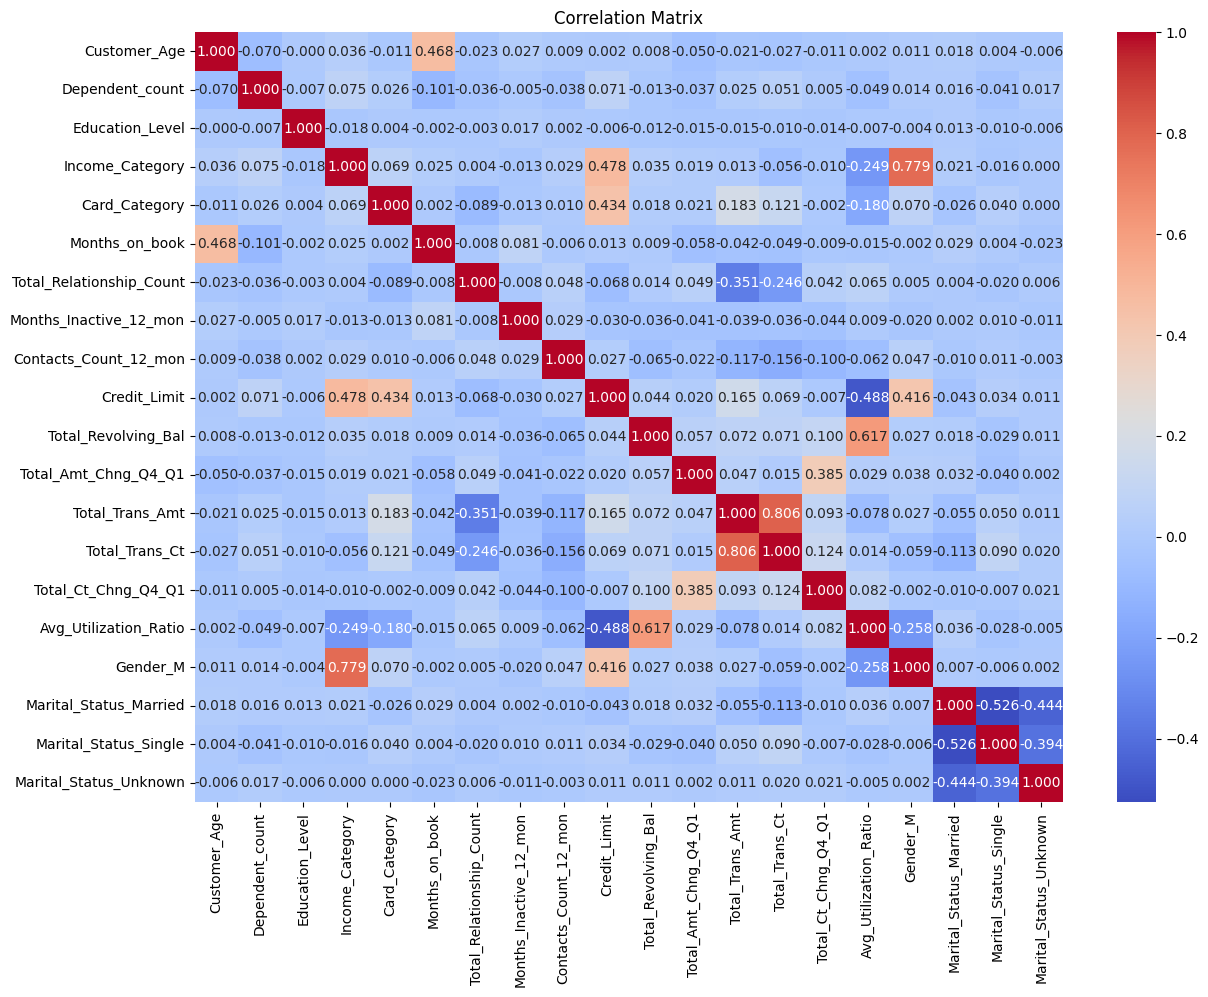

In [17]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

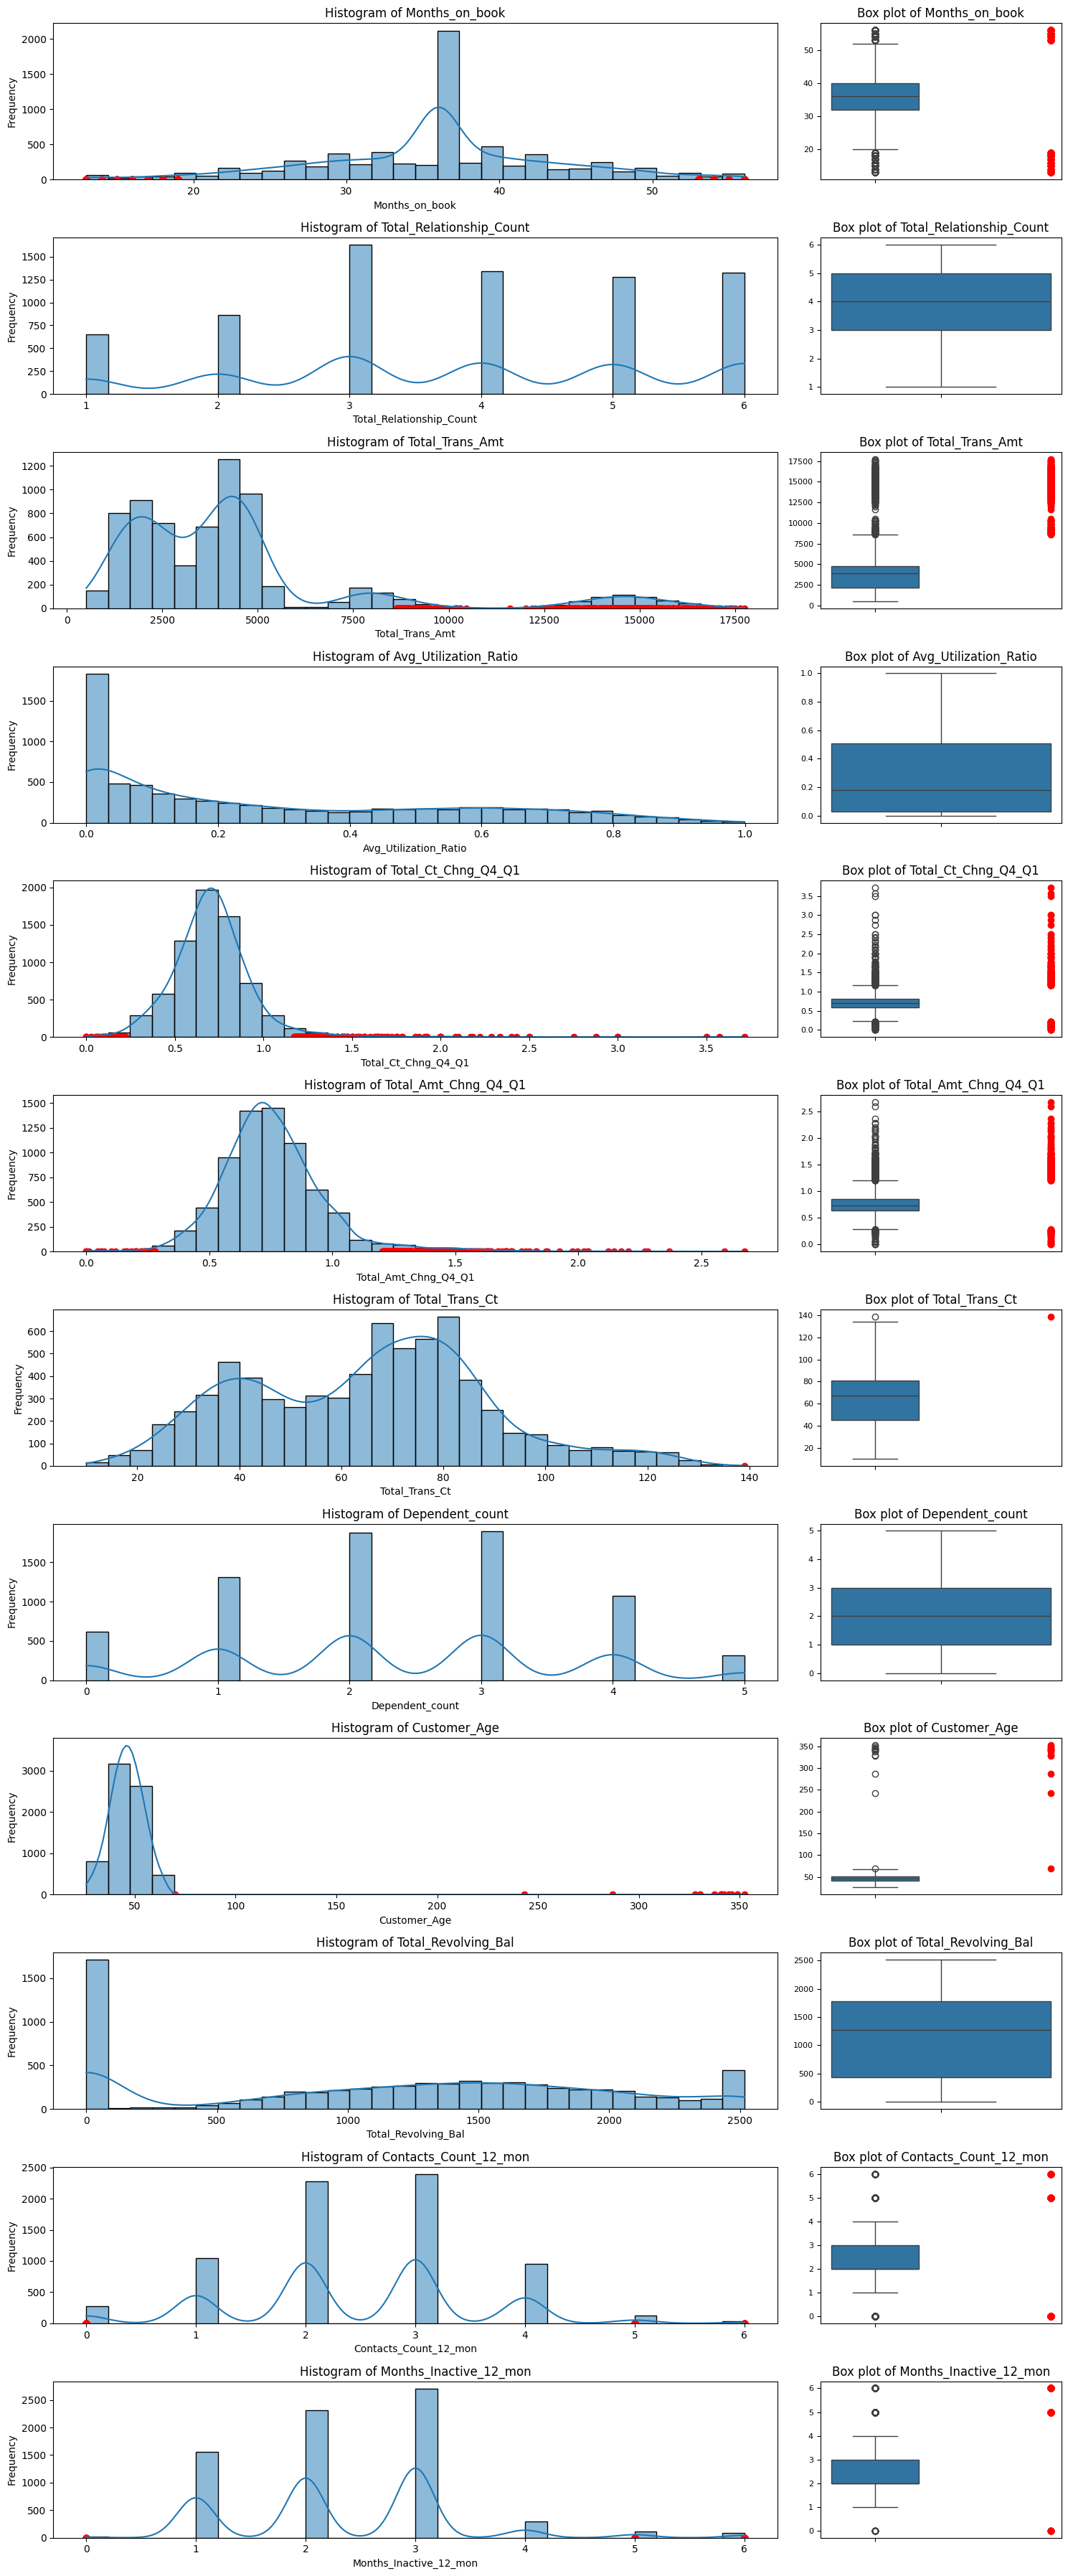

In [18]:
numeric_columns = ['Months_on_book', 'Total_Relationship_Count', 'Total_Trans_Amt',
                  'Avg_Utilization_Ratio', 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1',
                  'Total_Trans_Ct', 'Dependent_count', 'Customer_Age', 'Total_Revolving_Bal',
                  'Contacts_Count_12_mon', 'Months_Inactive_12_mon']
 

fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(15, 3*len(numeric_columns)), gridspec_kw={'width_ratios': [3, 1]})

# Plot histograms
for i, feature in enumerate(numeric_columns):
    sns.histplot(train_df[feature], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Frequency')

    # Detect and mark outliers using histogram
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    axes[i, 0].scatter(outliers[feature], [0] * len(outliers), color='red', label='Outliers')
    # train_df.loc[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound), feature] = np.nan

# Plot box plots 
for i, feature in enumerate(numeric_columns):
    sns.boxplot(data=train_df, y=feature, ax=axes[i, 1], orient='v', width=0.5)
    axes[i, 1].set_title(f'Box plot of {feature}')
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 1].tick_params(axis='y', labelsize=8)

    # Detect and mark outliers using box plot
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    axes[i, 1].scatter([1] * len(outliers), outliers[feature], color='red', label='Outliers')

plt.tight_layout()
plt.show()


In [19]:
# Outlier Detection

def wisker(column):
    q1, q3 = np.percentile(column, [5, 95])
    iqr = q3 - q1
    lw = q1 - 0.01 * iqr
    uw = q3 + 0.01 * iqr
    return lw, uw


In [20]:
# Detect ages greater than 125 and set them to NaN
train_df['Customer_Age'] = train_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)

# Impute the missing values
imputer = SimpleImputer(strategy='mean')
train_df['Customer_Age'] = imputer.fit_transform(train_df[['Customer_Age']])

In [21]:
wisker_columns = ['Months_on_book', 'Total_Trans_Amt', 'Avg_Utilization_Ratio',
                 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct',
                 'Contacts_Count_12_mon', 'Months_Inactive_12_mon']

for col in wisker_columns:
    lw, uw = wisker(train_df[col])
    outliers = (train_df[col] < lw) | (train_df[col] > uw)
    # train_df.loc[outliers, col] = np.nan
    train_df = train_df[~outliers]
    
# knn_imputer_columns = wisker_columns
# knn_imputer = KNNImputer(n_neighbors=100)
# train_df[knn_imputer_columns] = knn_imputer.fit_transform(train_df[knn_imputer_columns])


In [22]:
x_train = train_df.drop('Credit_Limit', axis='columns')
y_train = train_df['Credit_Limit']

x_test = test_df.drop('Credit_Limit', axis='columns')
y_test = test_df['Credit_Limit']

In [23]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [24]:
# from sklearn.feature_selection import SelectKBest, f_regression
# selector = SelectKBest(score_func=f_regression, k=3)
# X_train = selector.fit_transform(x_train, y_train)
# X_test = selector.transform(x_test)

In [25]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=16)  # Set the number of principal components
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

In [26]:
# Define the degree of the polynomial
degree = 3

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(x_train)

# Fit linear regression model
model = LinearRegression()
model.fit(x_poly, y_train)

# Predict
y_pred = model.predict(x_poly)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_pred)

# Calculate R-squared (R2)
r2 = r2_score(y_train, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 8264876.690966548
R-squared (R2): 0.8971275717923171


In [27]:
'''
Mean Squared Error (MSE): 8264876.690966548
R-squared (R2): 0.8971275717923171
'''

'\nMean Squared Error (MSE): 8264876.690966548\nR-squared (R2): 0.8971275717923171\n'